In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import statsmodels. api as sm
import statsmodels.formula.api as smf
import sys, os
import ast
import re
import seaborn as sns
import inspect
from collections import Counter

In [3]:
sns.__version__

'0.10.0'

# Basic features

In [77]:
CURRENTDIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))))
results = pd.read_excel(os.path.join(CURRENTDIR,"data/extracted_data_3.xlsx"))

In [86]:
results.columns

Index(['file', 'locutor', 'block', 'conv', 'it', 'conv_id_unif', 'tier',
       'content_complexity', 'count_syllables', 'extract_sentiment',
       'extract_subjectivity', 'lexical_richness', 'linguistic_complexity',
       'mean_ipu_lgth', 'nb_ipu', 'nb_tokens', 'nratio_discourse',
       'nratio_feedback', 'nratio_filled_pause', 'qt_discourse', 'qt_feedback',
       'qt_filled_pause', 'ratio_discourse', 'ratio_feedback',
       'ratio_filled_pause', 'ratio_silence_lgth', 'speech_rate',
       'speech_rate_2', 'speech_rate_max', 'speech_rate_mean',
       'speech_rate_min', 'speech_rate_min4', 'sum_ipu_lgth', 'extract_text'],
      dtype='object')

In [88]:
remove_loc = [1,4,19,23]
results = results[~results.locutor.isin(remove_loc)]

In [89]:
int_cols = ['lexical_richness', 'linguistic_complexity', 
       'count_syllables', 'nb_ipu', 'mean_ipu_lgth', 'sum_ipu_lgth', 
       'ratio_discourse', 'nratio_feedback', 'ratio_filled_pause', 'qt_discourse', 'qt_feedback',
       'qt_filled_pause']
d = results[int_cols]

In [7]:
def plot_corrmat(d, figsize=(20,20)):
    # Compute the correlation matrix
    corr = d.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., vmin=-1., center=0, annot=True, ax=ax,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

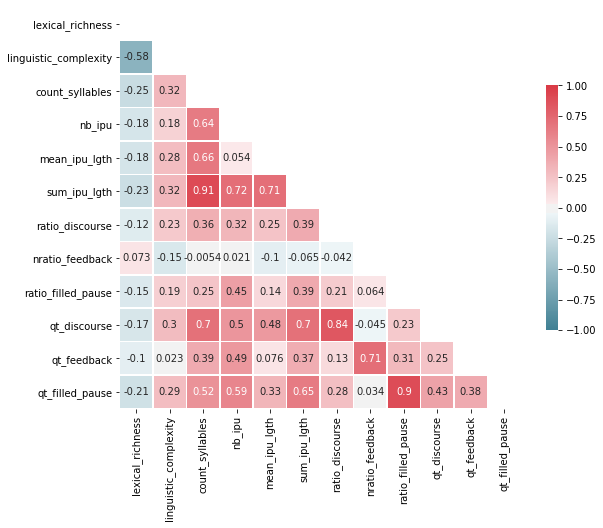

In [91]:
plot_corrmat(d, figsize=(9,9))

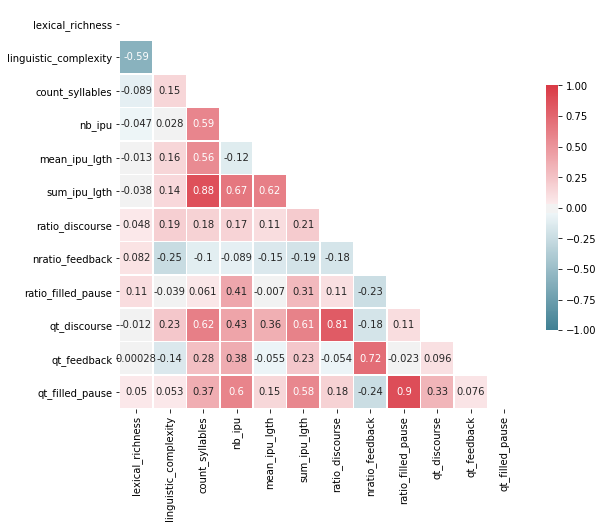

In [95]:
plot_corrmat(d[results.tier == 'participant'], figsize=(9,9))

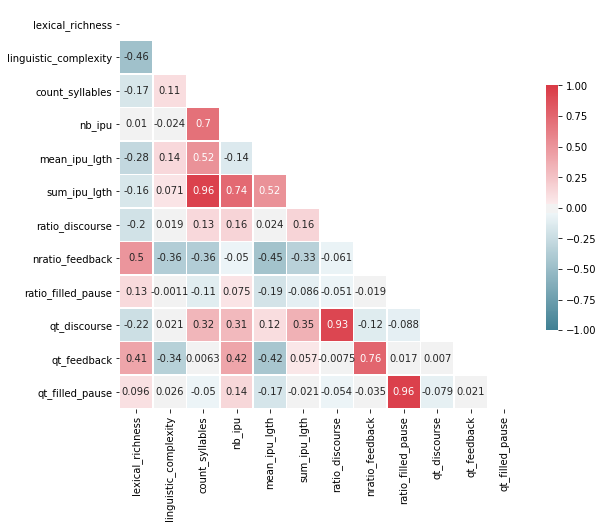

In [94]:
plot_corrmat(d[(results.tier == 'conversant') & (results.conv == 2)], figsize=(9,9))

**Participant - conversant correlation**

With human agent

In [96]:
main_cols = ['locutor', 'block', 'conv', 'it', 'conv_id_unif']

participant = results[(results.tier == 'participant') & (results.conv == 1)][main_cols+int_cols].reset_index(drop=True)
conversant = results[(results.tier == 'conversant') & (results.conv == 1)][main_cols+int_cols].reset_index(drop=True)
# create merge data
merres = pd.merge(participant, conversant, on=main_cols, suffixes=('_part', '_conv'), validate="one_to_one")

In [97]:
d = merres[[x+'_part' for x in int_cols]+[x+'_conv' for x in int_cols]].corr()
p = {}
for col in int_cols:
    p[col] = d[col+'_part'][col+'_conv']
pH = pd.Series(p, name = 'conv_part_corr_H')
#pH

With robotic agent

In [98]:
participant = results[(results.tier == 'participant') & (results.conv == 2)][main_cols+int_cols].reset_index(drop=True)
conversant = results[(results.tier == 'conversant') & (results.conv == 2)][main_cols+int_cols].reset_index(drop=True)
# create merge data
merres = pd.merge(participant, conversant, on=main_cols, suffixes=('_part', '_conv'), validate="one_to_one")
d = merres[[x+'_part' for x in int_cols]+[x+'_conv' for x in int_cols]].corr()
p = {}
for col in int_cols:
    p[col] = d[col+'_part'][col+'_conv']
pR = pd.Series(p, name = 'conv_part_corr_R')
#pR

global

In [99]:
participant = results[(results.tier == 'participant')][main_cols+int_cols].reset_index(drop=True)
conversant = results[(results.tier == 'conversant')][main_cols+int_cols].reset_index(drop=True)
# create merge data
merres = pd.merge(participant, conversant, on=main_cols, suffixes=('_part', '_conv'), validate="one_to_one")
d = merres[[x+'_part' for x in int_cols]+[x+'_conv' for x in int_cols]].corr()
p = {}
for col in int_cols:
    p[col] = d[col+'_part'][col+'_conv']
pA = pd.Series(p, name = 'conv_part_corr_A')
#pA

In [100]:
pd.concat([pH, pR, pA], axis=1)

,conv_part_corr_H,conv_part_corr_R,conv_part_corr_A
lexical_richness,0.148457,0.166865,0.174168
linguistic_complexity,0.192499,0.031398,0.067391
count_syllables,-0.143749,-0.238101,0.013631
nb_ipu,-0.083378,0.018455,-0.068361
mean_ipu_lgth,-0.081290,-0.113778,0.052013
sum_ipu_lgth,-0.446398,-0.350235,-0.171522
ratio_discourse,-0.025007,-0.007396,-0.053385
nratio_feedback,-0.164462,-0.125709,0.043321
ratio_filled_pause,0.038758,0.021434,-0.061972
qt_discourse,-0.040499,-0.080142,-0.022849


In [101]:
pd.concat([pH, pR, pA], axis=1).to_excel(os.path.join(CURRENTDIR,'data_analysis/_exploration/corr_conv_part.xlsx'))

# Alignment features

In [17]:
align = pd.read_excel(os.path.join(CURRENTDIR,"data/extracted_align_data_2.xlsx"))

In [18]:
align.head()

,file,locutor,block,conv,it,Trial,prime,common_lemmas,len_cl,len_pl,...,lilla,log_lilla,midlog_lilla,prime_contentw,prime_lemmas,prime_only_lemmas,scc_lex,target_contentw,target_lemmas,target_only_lemmas
0,S01_Sess1_CONV1_001,1,1,1,1,0,conversant,batman masque super-héros,3,13,...,0.011111,-4.499810,0.535865,18,alimentation batman beau bouche brillant chose...,alimentation beau bouche brillant chose grand ...,-2.139394,15,agir aubergine batman concerner croire dire fl...,agir aubergine concerner croire dire flou imag...
1,S01_Sess1_CONV1_001,1,1,1,1,0,participant,batman masque super-héros,3,15,...,0.011029,-4.507190,0.535160,17,agir aubergine batman concerner croire dire fl...,agir aubergine concerner croire dire flou imag...,-1.890909,16,alimentation batman beau bouche brillant chose...,alimentation beau bouche brillant chose grand ...
2,S01_Sess1_CONV1_003,1,1,1,3,1,conversant,alimentation citron fruit légume manger masque...,9,22,...,0.006250,-5.075174,0.485925,24,alimentation batman bizarre chose citron cockt...,batman bizarre chose cocktail histoire limer m...,0.612121,20,agir alimentation citron concerner demi dire f...,agir concerner demi dire image lier penser pub...
3,S01_Sess1_CONV1_003,1,1,1,3,1,participant,alimentation citron fruit légume manger masque...,9,20,...,0.017857,-4.025352,1.446346,24,agir alimentation citron concerner demi dire f...,agir concerner demi dire image lier penser pub...,-1.921212,21,alimentation batman bizarre chose citron cockt...,batman bizarre chose cocktail histoire limer m...
4,S01_Sess1_CONV1_005,1,1,1,5,2,conversant,citron enfant fruit légume man pomme spider,7,18,...,0.007018,-4.959342,0.630354,30,agrume cibler citron enfant fruit idée légume ...,agrume cibler idée manger mettre orange penser...,-2.703030,19,adhérer agir amusant capacité citron dire enfa...,adhérer agir amusant capacité dire image impre...


In [19]:
align.columns

Index(['file', 'locutor', 'block', 'conv', 'it', 'Trial', 'prime',
       'common_lemmas', 'len_cl', 'len_pl', 'len_pol', 'len_tol', 'len_tl',
       'lilla', 'log_lilla', 'midlog_lilla', 'prime_contentw', 'prime_lemmas',
       'prime_only_lemmas', 'scc_lex', 'target_contentw', 'target_lemmas',
       'target_only_lemmas'],
      dtype='object')

In [20]:
d = align[['len_pol', 'len_tol', 'lilla', 'midlog_lilla', 'len_pl', 'len_tl', 'len_cl']]
d['len_p*t'] = d.len_pl * d.len_tl

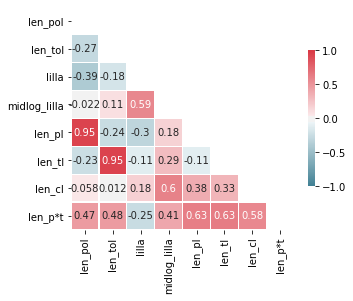

In [21]:
plot_corrmat(d[(align.prime == 'participant')], figsize=(5,5))

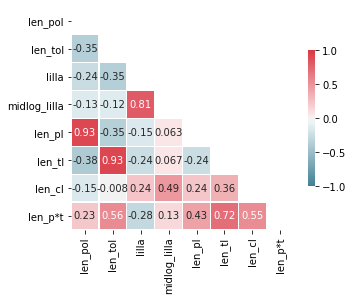

In [22]:
plot_corrmat(d[(align.prime == 'conversant') & (align.conv == 1)], figsize=(5,5))

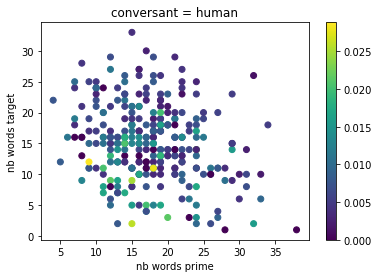

In [23]:
sc = plt.scatter(d[(align.prime == 'conversant') & (align.conv == 1)]['len_pl'], d[(align.prime == 'conversant') & (align.conv == 1)]['len_tl'], c=d[(align.prime == 'conversant') & (align.conv == 1)]['lilla'])
plt.colorbar(sc)
plt.xlabel('nb words prime')
plt.ylabel('nb words target')
plt.title('conversant = human')
plt.show()

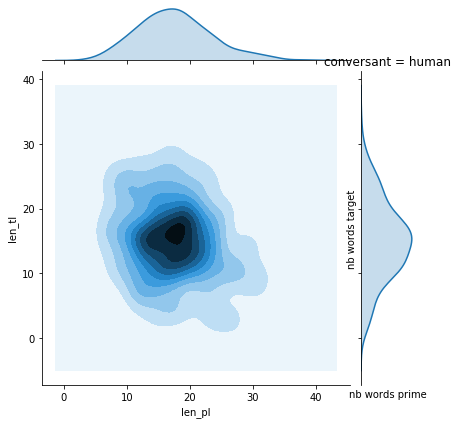

In [24]:
sns.jointplot(d[(align.prime == 'conversant') & (align.conv == 1)]['len_pl'], d[(align.prime == 'conversant') & (align.conv == 1)]['len_tl'], kind='kde')
plt.xlabel('nb words prime')
plt.ylabel('nb words target')
plt.title('conversant = human')
plt.show()

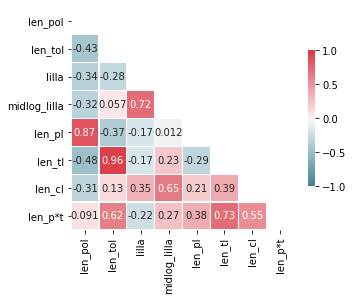

In [25]:
plot_corrmat(d[(align.prime == 'conversant') & (align.conv == 2)], figsize=(5,5))

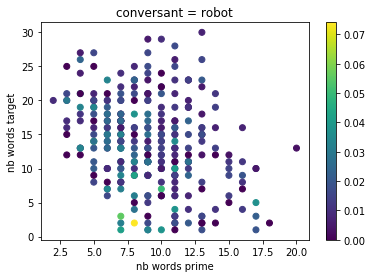

In [26]:
sc = plt.scatter(d[(align.prime == 'conversant') & (align.conv == 2)]['len_pl'], d[(align.prime == 'conversant') & (align.conv == 2)]['len_tl'], c=d[(align.prime == 'conversant') & (align.conv == 2)]['lilla'])
plt.colorbar(sc)
plt.xlabel('nb words prime')
plt.ylabel('nb words target')
plt.title('conversant = robot')
plt.show()

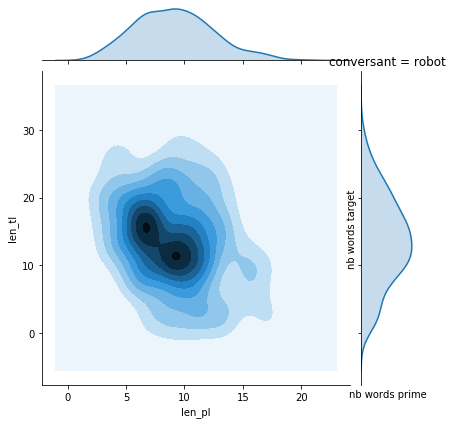

In [27]:
sns.jointplot(d[(align.prime == 'conversant') & (align.conv == 2)]['len_pl'], d[(align.prime == 'conversant') & (align.conv == 2)]['len_tl'], kind='kde')
plt.xlabel('nb words prime')
plt.ylabel('nb words target')
plt.title('conversant = robot')
plt.show()

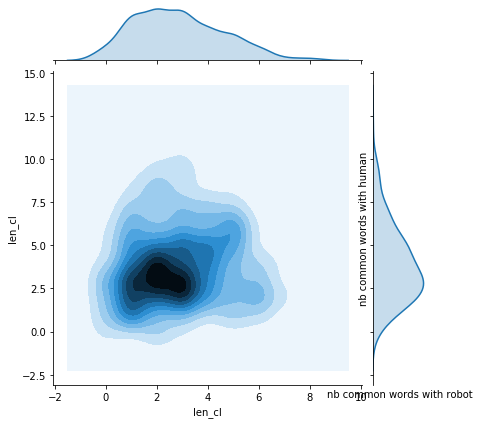

In [28]:
sns.jointplot(d[(align.prime == 'conversant') & (align.conv == 2)]['len_cl'], d[(align.prime == 'conversant') & (align.conv == 1)]['len_cl'], kind='kde')
plt.xlabel('nb common words with robot')
plt.ylabel('nb common words with human')
plt.show()

### Most common common words

In [29]:
words = [x.split(' ') for x in align[align.prime == 'conversant']['common_lemmas'] if str(x) != 'nan']
words = [y for x in words for y in x] # flatter

In [30]:
len(words), len(set(words)) # unique words vs nb words

(2008, 295)

In [31]:
words_df = nltk.FreqDist(words)

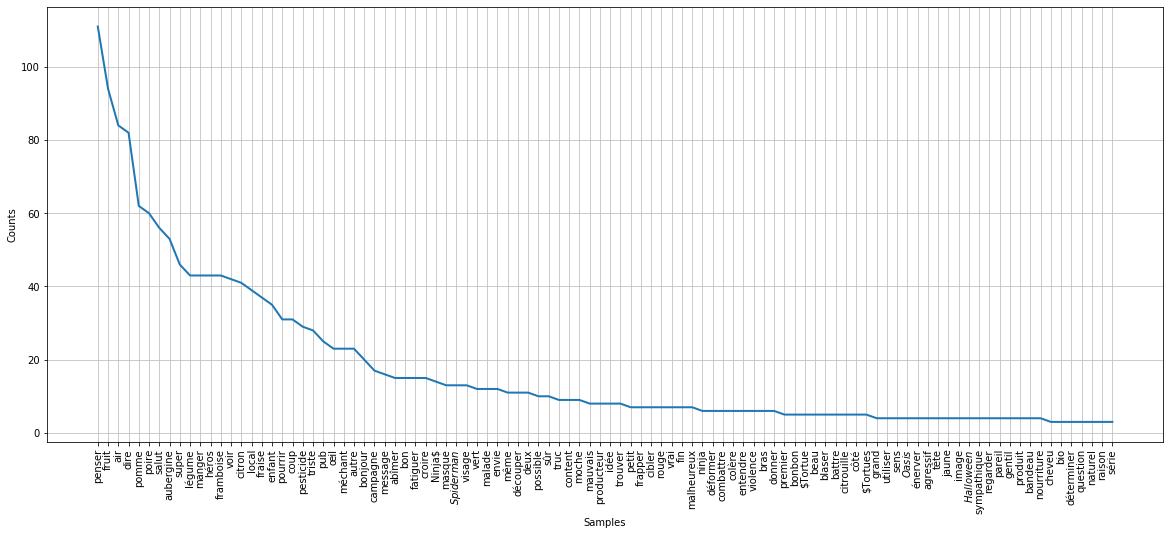

In [32]:
plt.figure(figsize=(20, 8))
words_df.plot(100)

"air" : probably "il a l'air"

In [65]:
def plot_most_frequents(df, col, prime="conversant", conv=2, figsize=(20,5), nb_plot=100, reverse_axis=False):
    words_r = [x.split(' ') for x in df[(df.prime == prime) & (df.conv == conv)][col] if str(x) != 'nan']
    words_r = [y for x in words_r for y in x] # flatten
    # print
    print("Number of repetitions accross conversations: {}\t Unique words: {}".format(len(words_r), len(set(words_r))))
    # plot
    words_r_df = nltk.FreqDist(words_r)
    fig, ax = plt.subplots(figsize=(20, 5))
    if reverse_axis:
        # https://stackoverflow.com/questions/14406214/moving-x-axis-to-the-top-of-a-plot-in-matplotlib
        ax.invert_yaxis()
        ax.xaxis.tick_top()
    words_r_df.plot(100)
    return words_r

**Robot vs Human:**

Number of repetitions accross conversations: 847	 Unique words: 85


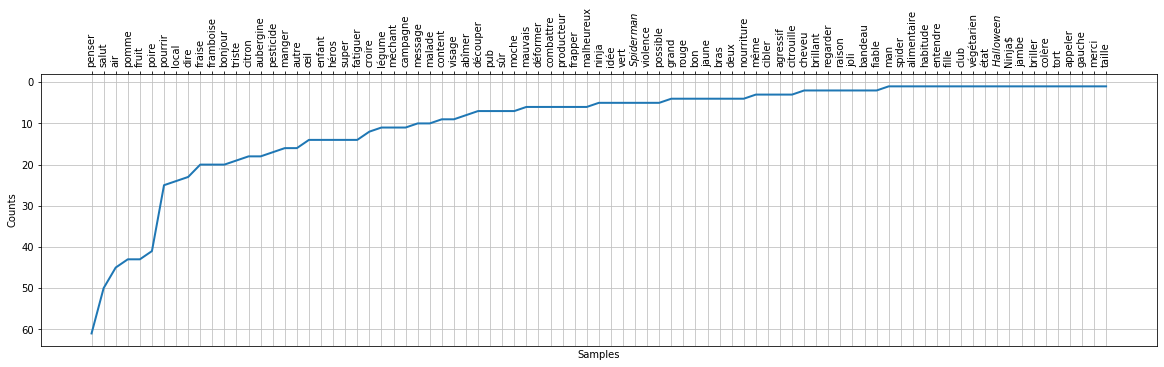

In [76]:
words_r = plot_most_frequents(align, 'common_lemmas', prime="conversant", conv=2, figsize=(20,5), nb_plot=80, reverse_axis=True)

Number of repetitions accross conversations: 1161	 Unique words: 274


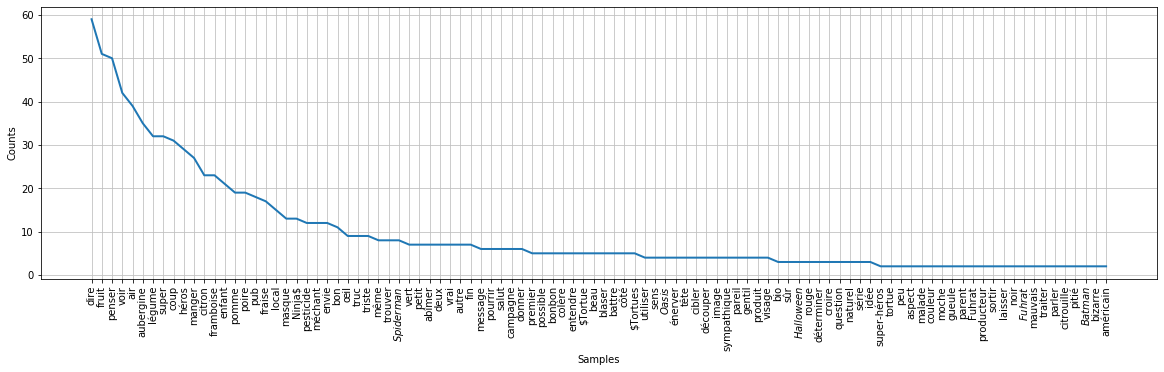

In [67]:
words_h = plot_most_frequents(align, 'common_lemmas', prime="conversant", conv=1, figsize=(20,5), nb_plot=100)

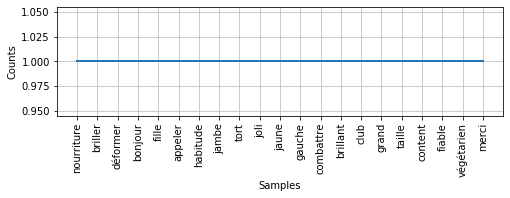

In [68]:
plt.figure(figsize=(8,2))
nltk.FreqDist(list(set(words_r) - set(words_h))).plot()

### Agent only lemmas
Robot

Number of repetitions accross conversations: 1863	 Unique words: 143


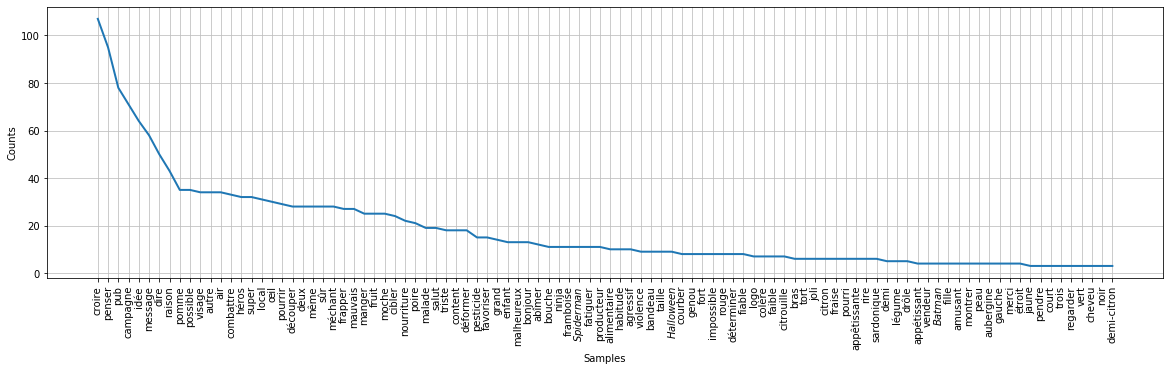

In [69]:
words_h = plot_most_frequents(align, 'prime_only_lemmas', prime="conversant", conv=2, figsize=(20,5), nb_plot=100)

Human

Number of repetitions accross conversations: 4087	 Unique words: 966


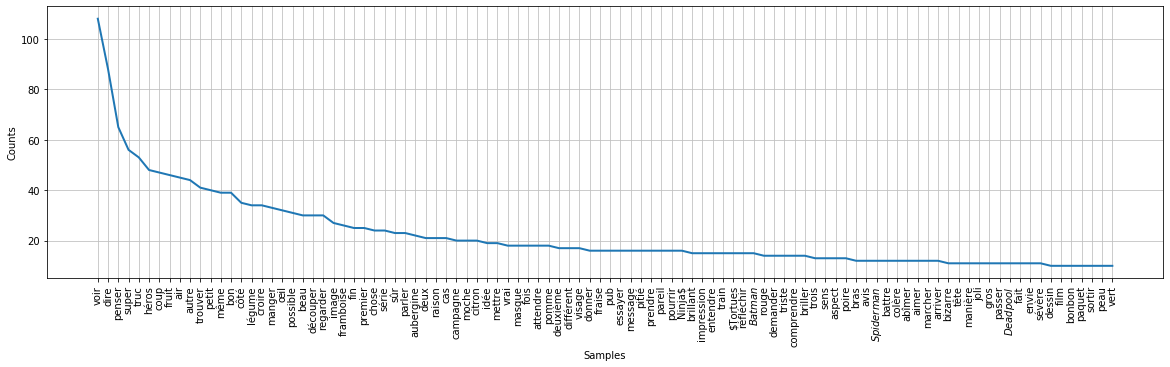

In [71]:
words_h = plot_most_frequents(align, 'prime_only_lemmas', prime="conversant", conv=1, figsize=(20,5), nb_plot=100)

### Agent words

Number of repetitions accross conversations: 5248	 Unique words: 1033


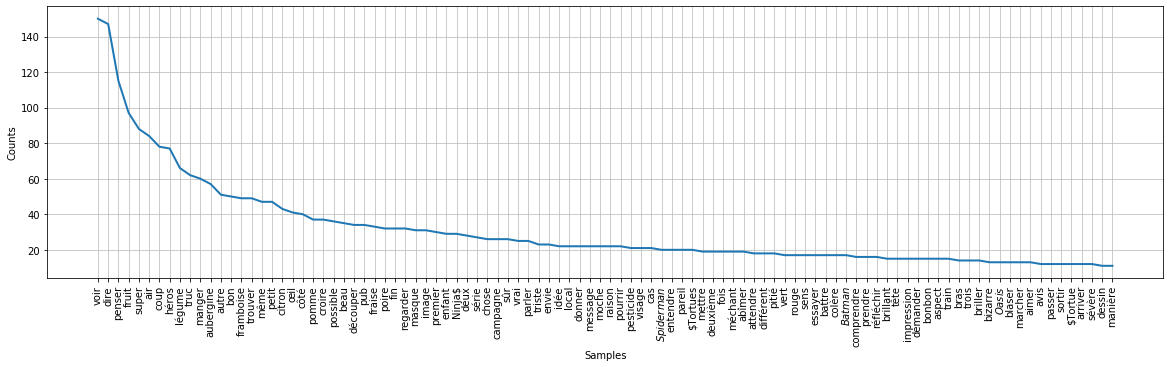

In [75]:
words_h = plot_most_frequents(align, 'prime_lemmas', prime="conversant", conv=1, figsize=(20,5), nb_plot=80)

Number of repetitions accross conversations: 2710	 Unique words: 147


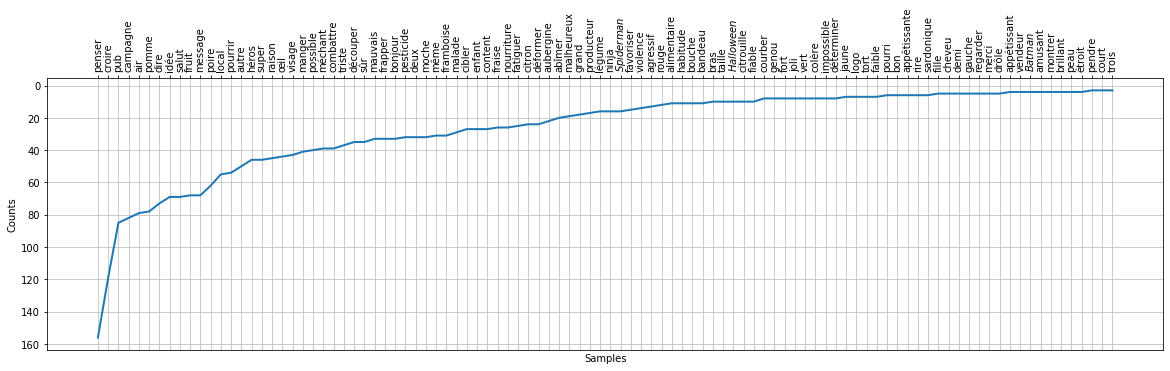

In [73]:
words_h = plot_most_frequents(align, 'prime_lemmas', prime="conversant", conv=2, figsize=(20,5), nb_plot=80, reverse_axis=True)

### Counting used words overall
**Conversant**

In [39]:
words_r = [x.split(' ') for x in align[(align.prime == 'conversant') & (align.conv == 1)]['prime_lemmas'] if str(x) != 'nan']
words_r = [y for x in words_r for y in x] # flatter
print(len(words_r), len(set(words_r)))

5248 1033


In [40]:
words_r = [x.split(' ') for x in align[(align.prime == 'conversant') & (align.conv == 2)]['prime_lemmas'] if str(x) != 'nan']
words_r = [y for x in words_r for y in x] # flatter
print(len(words_r), len(set(words_r)))

2710 147


**Participant**

In [41]:
words_r = [x.split(' ') for x in align[(align.prime == 'participant') & (align.conv == 1)]['prime_lemmas'] if str(x) != 'nan']
words_r = [y for x in words_r for y in x] # flatten
print(len(words_r), len(set(words_r)))

4498 1030


In [42]:
words_r = [x.split(' ') for x in align[(align.prime == 'participant') & (align.conv == 2)]['prime_lemmas'] if str(x) != 'nan']
words_r = [y for x in words_r for y in x] # flatten
print(len(words_r), len(set(words_r)))

4061 839


**Going Further**: number of words used / time spoken

Step 1: merging both datasets

In [43]:
meralign = pd.merge(merres, align[(align.prime == 'conversant')], on=['locutor', 'block', 'conv', 'it'], validate="one_to_one")

In [44]:
meralign.head()

,locutor,block,conv,it,conv_id_unif,lexical_richness_part,linguistic_complexity_part,content_complexity_part,count_syllables_part,nb_ipu_part,...,lilla,log_lilla,midlog_lilla,prime_contentw,prime_lemmas,prime_only_lemmas,scc_lex,target_contentw,target_lemmas,target_only_lemmas
0,1,1,1,1,0,0.191489,0.404255,0.191489,77,13,...,0.011111,-4.499810,0.535865,18,alimentation batman beau bouche brillant chose...,alimentation beau bouche brillant chose grand ...,-2.139394,15,agir aubergine batman concerner croire dire fl...,agir aubergine concerner croire dire flou imag...
1,1,1,1,3,1,0.163265,0.306122,0.295918,124,16,...,0.006250,-5.075174,0.485925,24,alimentation batman bizarre chose citron cockt...,batman bizarre chose cocktail histoire limer m...,0.612121,20,agir alimentation citron concerner demi dire f...,agir concerner demi dire image lier penser pub...
2,1,1,1,5,2,0.109244,0.411765,0.285714,150,15,...,0.007018,-4.959342,0.630354,30,agrume cibler citron enfant fruit idée légume ...,agrume cibler idée manger mettre orange penser...,-2.703030,19,adhérer agir amusant capacité citron dire enfa...,adhérer agir amusant capacité dire image impre...
3,1,1,2,2,0,0.101010,0.414141,0.222222,120,17,...,0.019737,-3.925268,0.597148,19,appétissant dire découper grand man manger pom...,appétissant découper manger pub visage,0.745455,8,aubergine dire grand man masque pattern pomme ...,aubergine masque pattern poser rouge sens sign...
4,1,1,2,4,1,0.194444,0.314815,0.305556,97,15,...,0.016835,-4.084294,0.878159,27,air campagne cibler enfant local légume manger...,campagne cibler enfant pub raison,-4.933333,11,agir air aliment alimentation aubergine batman...,agir aliment alimentation aubergine batman che...


In [45]:
def count_uniques(l):
    words = [x.split(' ') for x in l if str(x) != 'nan']
    words = [y for x in words for y in x]
    return len(set(words))

In [46]:
gb = meralign.groupby(by=['conv']).agg({'sum_ipu_lgth_part':'sum', 'sum_ipu_lgth_conv':'sum', 'prime_lemmas':count_uniques, 'target_lemmas':count_uniques})
gb['part_ratio'] = gb.target_lemmas/gb.sum_ipu_lgth_part
gb['conv_ratio'] = gb.prime_lemmas/gb.sum_ipu_lgth_conv
gb

,sum_ipu_lgth_part,sum_ipu_lgth_conv,prime_lemmas,target_lemmas,part_ratio,conv_ratio
conv,,,,,,
1,5706.440090,6967.317462,1033,1030,0.180498,0.148264
2,5329.485342,3125.378448,147,839,0.157426,0.047034


Conclusion: robot uses a smaller amount of different words. Also participants tend to use fewer different words with the robot. (significant?)

Considering all words pronounced:

In [47]:
def count_words(l):
    words = [x.split(' ') for x in l if str(x) != 'nan']
    words = [y for x in words for y in x]
    return len(words)

gb = meralign.groupby(by=['conv']).agg({'sum_ipu_lgth_part':'sum', 'sum_ipu_lgth_conv':'sum', 'prime_lemmas':count_words, 'target_lemmas':count_words})
gb['part_ratio'] = gb.target_lemmas/gb.sum_ipu_lgth_part
gb['conv_ratio'] = gb.prime_lemmas/gb.sum_ipu_lgth_conv
gb

,sum_ipu_lgth_part,sum_ipu_lgth_conv,prime_lemmas,target_lemmas,part_ratio,conv_ratio
conv,,,,,,
1,5706.440090,6967.317462,5248,4498,0.788232,0.753231
2,5329.485342,3125.378448,2710,4061,0.761987,0.867095


Conclusion: robot uses a larger amount of content words (since it does not hesitate nor anything).

Let's have a look at the amount of words shared / not shared between participant and conversant:

In [48]:
gb = meralign.groupby(by=['conv']).agg({'sum_ipu_lgth_part':'sum', 'sum_ipu_lgth_conv':'sum', 'prime_only_lemmas':count_uniques, 'target_only_lemmas':count_uniques})
gb['part_ratio'] = gb.target_only_lemmas/gb.sum_ipu_lgth_part
gb['conv_ratio'] = gb.prime_only_lemmas/gb.sum_ipu_lgth_conv
gb

,sum_ipu_lgth_part,sum_ipu_lgth_conv,prime_only_lemmas,target_only_lemmas,part_ratio,conv_ratio
conv,,,,,,
1,5706.440090,6967.317462,966,962,0.168581,0.138647
2,5329.485342,3125.378448,143,828,0.155362,0.045754


In [49]:
gb = meralign.groupby(by=['conv']).agg({'sum_ipu_lgth_part':'sum', 'sum_ipu_lgth_conv':'sum', 'prime_only_lemmas':count_words, 'target_only_lemmas':count_words})
gb['part_ratio'] = gb.target_only_lemmas/gb.sum_ipu_lgth_part
gb['conv_ratio'] = gb.prime_only_lemmas/gb.sum_ipu_lgth_conv
gb

,sum_ipu_lgth_part,sum_ipu_lgth_conv,prime_only_lemmas,target_only_lemmas,part_ratio,conv_ratio
conv,,,,,,
1,5706.440090,6967.317462,4087,3337,0.584778,0.586596
2,5329.485342,3125.378448,1863,3214,0.603060,0.596088


WOW!!!

In [50]:
gb = meralign.groupby(by=['conv']).agg({'sum_ipu_lgth_part':'sum', 'sum_ipu_lgth_conv':'sum', 'common_lemmas':count_uniques})
gb['part_ratio'] = gb.common_lemmas/gb.sum_ipu_lgth_part
gb['conv_ratio'] = gb.common_lemmas/gb.sum_ipu_lgth_conv
gb

,sum_ipu_lgth_part,sum_ipu_lgth_conv,common_lemmas,part_ratio,conv_ratio
conv,,,,,
1,5706.440090,6967.317462,274,0.048016,0.039326
2,5329.485342,3125.378448,85,0.015949,0.027197


In [51]:
gb = meralign.groupby(by=['conv']).agg({'sum_ipu_lgth_part':'sum', 'sum_ipu_lgth_conv':'sum', 'common_lemmas':count_words})
gb['part_ratio'] = gb.common_lemmas/gb.sum_ipu_lgth_part
gb['conv_ratio'] = gb.common_lemmas/gb.sum_ipu_lgth_conv
gb

,sum_ipu_lgth_part,sum_ipu_lgth_conv,common_lemmas,part_ratio,conv_ratio
conv,,,,,
1,5706.440090,6967.317462,1161,0.203454,0.166635
2,5329.485342,3125.378448,847,0.158927,0.271007
